In [1]:
import pickle
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.preprocessing import image
import tensorflow as tf
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input, Dropout
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.utils import np_utils
import time

In [2]:
pickle_in_features = open('/research/Projects/Potato plant disease/features.pkl', 'rb')
x = pickle.load(pickle_in_features)
x = np.array(x, dtype=np.float64)

pickle_in_labels = open('/research/Projects/Potato plant disease/labels.pkl', 'rb')
y = pickle.load(pickle_in_labels)
y = np.array(y, dtype=np.int64)
y = to_categorical(y)

### Splitting the data

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.7, random_state=2)

In [5]:
print(x_train.shape)
print(y_train.shape)

(2105, 224, 224, 3)
(2105, 3)


### Loading the ResNet50 model

In [10]:
num_classes = 3

image_input = Input(shape=(224, 224, 3))

model = ResNet50(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()

last_layer = model.get_layer('avg_pool').output
X = last_layer
d1 = Dropout(0.1)(X)
out = Dense(num_classes, activation='softmax', name='output_layer')(d1)
custom_resnet_model = Model(inputs=image_input,outputs= out)
custom_resnet_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [11]:
for layer in custom_resnet_model.layers[:-1]:
    layer.trainable = False


custom_resnet_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

t=time.time()
hist = custom_resnet_model.fit(x_train, y_train, batch_size=32, epochs=15, verbose=2, validation_split=0.2)
print('Training time: %s' % (t - time.time()))


Epoch 1/15
53/53 [==============================] - 170s 3s/step - loss: 0.6627 - accuracy: 0.3624 - val_loss: 0.6175 - val_accuracy: 0.4204
Epoch 2/15
53/53 [==============================] - 157s 3s/step - loss: 0.6263 - accuracy: 0.4408 - val_loss: 0.6038 - val_accuracy: 0.5131
Epoch 3/15
53/53 [==============================] - 149s 3s/step - loss: 0.6025 - accuracy: 0.4918 - val_loss: 0.5819 - val_accuracy: 0.5867
Epoch 4/15
53/53 [==============================] - 152s 3s/step - loss: 0.5867 - accuracy: 0.5238 - val_loss: 0.5789 - val_accuracy: 0.4656
Epoch 5/15
53/53 [==============================] - 154s 3s/step - loss: 0.5710 - accuracy: 0.5488 - val_loss: 0.5657 - val_accuracy: 0.5107
Epoch 6/15
53/53 [==============================] - 157s 3s/step - loss: 0.5563 - accuracy: 0.5546 - val_loss: 0.5464 - val_accuracy: 0.6627
Epoch 7/15
53/53 [==============================] - 142s 3s/step - loss: 0.5447 - accuracy: 0.6000 - val_loss: 0.5407 - val_accuracy: 0.6105
Epoch 8/15
53

In [12]:
(loss, accuracy) = custom_resnet_model.evaluate(x_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

91/91 [==============================] - 64s 705ms/step - loss: 0.5045 - accuracy: 0.7375
[INFO] loss=0.5045, accuracy: 73.7542%


### Plotting the graphs

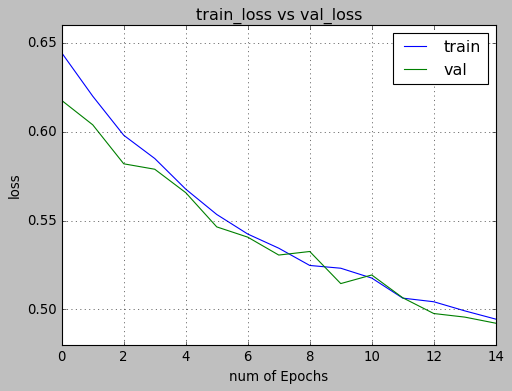

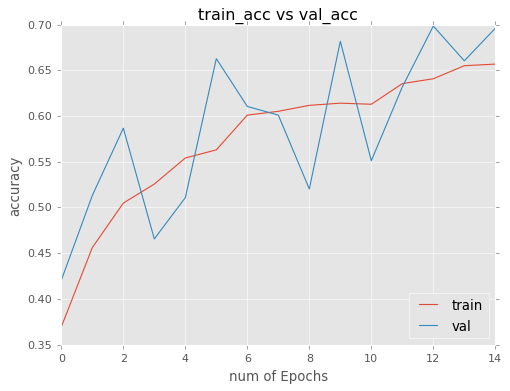

In [13]:
import matplotlib.pyplot as plt

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(15)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['ggplot'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])